In [1]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import matplotlib.pyplot as plt

In [2]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="normal")
        super(attention,self).build(input_shape)


    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

In [3]:
N_STEPS = 7
LOOKUP_STEPS = [1]
STOCK = 'AMZN'

date_now = tm.strftime('%Y-%m-%d')
yesterday  = dt.date.today() - dt.timedelta(days=2)
date_3_years_back = (yesterday - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [5]:
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
init_df['date'] = init_df.index

[9.02330017e+01 9.00855026e+01 8.97884979e+01 8.94100037e+01
 8.92939987e+01 8.85824966e+01 8.89000015e+01 8.76555023e+01
 8.77300034e+01 8.69745026e+01 8.76265030e+01 8.76395035e+01
 8.72764969e+01 8.67354965e+01 8.72860031e+01 8.86920013e+01
 8.98470001e+01 9.09254990e+01 9.00400009e+01 8.90800018e+01
 8.84980011e+01 8.80345001e+01 8.70240021e+01 8.75800018e+01
 8.74755020e+01 8.69605026e+01 8.74359970e+01 8.80165024e+01
 8.80469971e+01 8.84605026e+01 8.95329971e+01 8.92014999e+01
 8.96139984e+01 8.93249969e+01 8.96500015e+01 8.94605026e+01
 9.34384995e+01 9.34899979e+01 9.23444977e+01 9.23919983e+01
 9.49004974e+01 9.37484970e+01 9.51439972e+01 9.53430023e+01
 9.45985031e+01 9.50524979e+01 9.41579971e+01 9.45650024e+01
 9.34720001e+01 9.31009979e+01 9.38970032e+01 9.32360001e+01
 9.45999985e+01 9.43730011e+01 9.42289963e+01 9.30820007e+01
 9.14169998e+01 9.26624985e+01 9.29000015e+01 9.35339966e+01
 1.00435997e+02 1.00209999e+02 1.02483498e+02 1.01993500e+02
 1.02511497e+02 1.039639

C:\Users\hanna\AppData\Local\Temp\ipykernel_8296\1930902855.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style='seaborn-whitegrid')


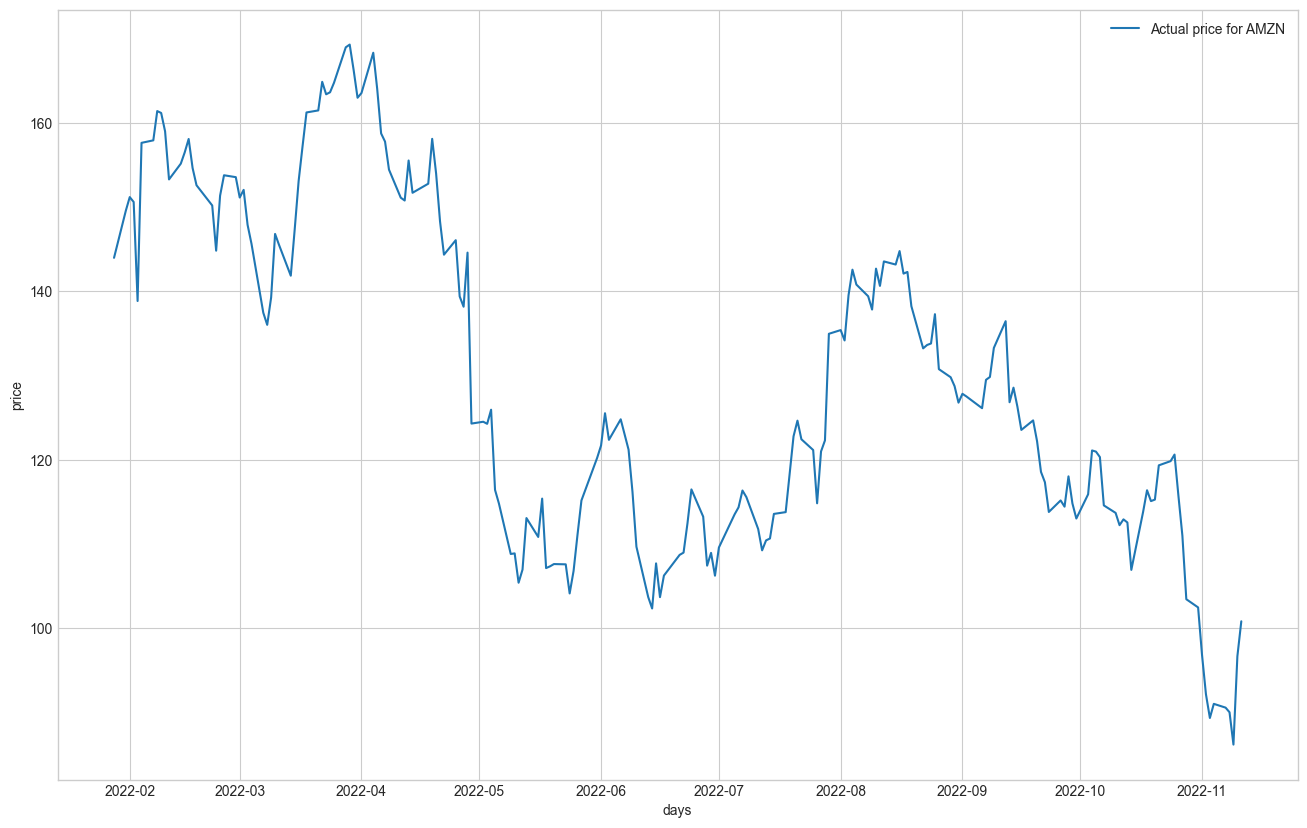

In [6]:
data = init_df['close']
data = np.append(data,0.005)
today = str(tm.strftime('%Y-%m-%d'))
print(data)

plt.style.use(style='seaborn-whitegrid')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [7]:
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [8]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(attention(return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(20))
  model.add(Dense(1))

  # model2 = Sequential()
  # model2.add(Embedding(n_unique_words, 128, input_length=maxlen))
  # model2.add(Bidirectional(LSTM(64, return_sequences=True)))
  # model2.add(attention(return_sequences=True)) # receive 3D and output 3D
  # model2.add(Dropout(0.5))
  # model2.add(Dense(1, activation='sigmoid'))
  # model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # model2.summary()


  BATCH_SIZE = 8
  EPOCHS = 100

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  model.summary()

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [9]:
def PrepareData():
  df = init_df.copy()
  df['future'] = df['close']
  last_sequence = np.array(df['close'][-7:])
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [10]:

predictions = []
print("started")
df, last_sequence, x_train, y_train = PrepareData()
x_train = x_train[:, :, :len(['close'])].astype(np.float32)
model = GetTrainedModel(x_train, y_train)
# print(last_sequence)
last_sequence = last_sequence[-N_STEPS:]
# print(last_sequence)
last_sequence = np.expand_dims(last_sequence, axis=0)
prediction = model.predict(last_sequence)
print(f"Prediction{prediction}")
predicted_price = scaler.inverse_transform(prediction)[0][0]
print(predicted_price)

predictions.append(round(float(predicted_price), 2))
print(predictions)

started


C:\Users\hanna\AppData\Local\Temp\ipykernel_8296\3779544858.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  last_sequence = np.array(last_sequence).astype(np.float32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 60)             14880     
                                                                 
 attention (attention)       (None, 7, 60)             67        
                                                                 
 dropout (Dropout)           (None, 7, 60)             0         
                                                                 
 lstm_1 (LSTM)               (None, 120)               86880     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense (Dense)               (None, 20)                2420      
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [11]:
scaler.inverse_transform(model.predict(last_sequence))[0][0]

# numbers = []
# for x in range(1):
#     numbers.append(program())
# print(numbers.sum/len(numbers))

1/1 [==============================] - 0s 50ms/step


101.11471